# Problema 3: Sistema de Alerta Temprana (Churn Rate)

El Lifetime Value (LTV) está disminuyendo. Sospechamos que los clientes están migrando sus compras principales a la competencia, dejándonos solo pedidos mínimos de "relleno". Se requiere identificar las alertas tempranas que expliquen el abandono y desarrollar un
modelo que pueda ser aplicado preventivamente.

## Retos específicos:

* Definir operativamente qué es se define como "cliente en fuga" para este modelo de negocio y para este ejercicio.
* **Preguntas de investigación:** Plantea una o más preguntas de investigación que ayuden a entender el problema y dale solución a través de los datos.
* **Capas de análisis sugeridas:** Análisis RFM (Recency, Frequency, Monetary) para segmentar a los clientes antes de aplicar el modelo de predicción, o si existe alguna otra capa que consideres importante puedes incluirla.
* **Recomendación de negocio:** Diseñe una estrategia de retención para el segmento de clientes "En Riesgo" pero con alto potencial de LTV, que recomendación adicional le das al negocio.

## Cliente en Fuga - Definición Operativa

Se define a un "Cliente en Fuga" como un cliente que solía realizar numerosas compras de muchos productos en el pasado y que, actualmente, ha disminuido significativamente su nivel de compra. 

## Preguntas de Investigación 

1. **Cómo ha cambiado el LTV (LifeTime Value) en los últimos dos años?** •	El lifetime value de la empresa calculado para 2025 es de 444752.56$, un incremento del 208.13% del desde 2023.
2. **¿Cuáles son las señales tempranas de un cliente en fuga?** Son una disminución significativa en la cantidad de productos comprados y en la cantidad de compras realizadas, por lo que el monto total gastado disminuye. 
3. **¿Cuántos clientes en fuga tiene la empresa para 2025?** Para el último trimestre de 2025, la empresa tiene 63 clientes en fuga de 480 clientes activos

In [1]:
import pandas as pd
import datetime as dt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm

## Importar datos 

In [2]:
# Importar Datos - Clientes

clientes = pd.read_csv('C:\\Users\\andre\\Documents\\Prueba Técnica - DroNena\\datos_prueba_tecnica_ciencia_datos\\maestro_clientes.csv', encoding='latin-1', delimiter=';')

In [3]:
# Importar Datos - Ventas Historicas

ventas = pd.read_csv('C:\\Users\\andre\\Documents\\Prueba Técnica - DroNena\\datos_prueba_tecnica_ciencia_datos\\Ventas_historicas.csv')

## Limpieza de datos - Ventas Históricas

### Pasos a seguir: 
1. **Verificar los datos importados** 
    * Número de columnas y filas
    * Valores nulos
    * Valores negativos
2. **Lidiar con los valores nulos**
    * CODCLI -> En estos casos, puede que existe un registro con el mismo número de factura que contienen el CODCLI por lo que se tomará ese como el CODCLI. Del resto, se eliminirán aquellas facturas. 
    * FECHAFAC -> Se seguirá el mismo procedimiento aplicado a los CODCLI faltantes, pero, en caso de que no se consiga un FECHAFAC válido, se tomará como fecha de la factura la fecha contenida en fechmes debido a que esta representa la última fecha del mes a la que pertenece dicha factura. 
    * CANTIDAD, VENTAS_BRUTAS, VENTAS_NETAS -> Debido a que queremos estudiar los hábitos de compra de los clientes y no contamos con la información esencial de la factura, se procederá a eliminar estos registros.
3. **Lidiar con valores cero**
    En caso de que la CANTIDAD sea igual 0, se eliminarán estos registros debido a que no aportan información de valor al estudio y pueda tratarse de un error. 
4. **Escoger columnas relevantes** 
    * Se consideran columnas relevantes como aquellas que aporten información de valor para la generación de resultados pertinentes al caso de negocio, por lo que se eliminarán columnas relacionadas con la información del proveedor, el producto o la zona del cliente, entre otras
5. **Agrupar por número de factura** 
    * Debido a que algunas facturas comprenden la venta de más de un producto se requiere agrupar estas ventas para simplificar los datos
6. **Cambiar fecha a tipo de datos date**
    * Se realizará un cambio de tipo para poder manipular las fechas de forma más fácil

In [4]:
# Verificar datos importados

# Numero de filas y columnas en cada dataset

print(f"Ventas: {ventas.shape[0]} filas, {ventas.shape[1]} columnas")

# Verificar columnas con valores nulos 
print("\nValores nulos en ventas por campo:")
print(ventas.isnull().sum())

# Verificar filas con valores negativos
print("\nFilas en ventas con VENTAS_BRUTAS negativas:")
print(ventas[ventas['VENTAS_BRUTAS'] < 0].shape[0])

Ventas: 1661296 filas, 13 columnas

Valores nulos en ventas por campo:
Unnamed: 0           0
FECHAFAC         18939
CODFACTURA           0
CODCLI           14786
ZONACLI              0
CODPROD              0
CODPROV              0
CANTIDAD         72947
PRECIO               1
NETO                 1
VENTAS_BRUTAS    72947
VENTAS_NETAS     72947
fechmes              1
dtype: int64

Filas en ventas con VENTAS_BRUTAS negativas:
0


In [5]:
# Procesamiento de Valores Nulos
# Se comienza eliminando los casos con mayor cantidad de valores nulos para luego ir avanzando hacia los casos con menor cantidad 
# de valores nulos, esto con el fin de disminuir el tiempo de procesamiento

# Filas con todos los campos CANTIDAD, VENTAS_BRUTAS y VENTAS_NETAS nulos 
ventas = ventas.dropna(subset=['CANTIDAD', 'VENTAS_BRUTAS', 'VENTAS_NETAS'], how='all')

# Filas con CANTIDAD igual a 0
ventas = ventas[ventas['CANTIDAD'] != 0]

# Reemplazar CODCLI nulos por CODCLI de otros datos con el mismo CODFACTURA
ventas['CODCLI'] = ventas.groupby('CODFACTURA')['CODCLI'].transform(lambda x: x.ffill().bfill())

# Eliminar filas con CODCLI nulo, cuyo numero de filas por CODFACTURA sea 1. Es decir, no hay manera de saber a que cliente corresponde esa factura, por lo tanto se eliminaran esas filas.
ventas = ventas.dropna(subset=['CODCLI'], how='any')

# Reemplazar FECHAFAC nulos por fecha de otros datos con el mismo CODFACTURA como se hizo con CODCLI
ventas['FECHAFAC'] = ventas.groupby('CODFACTURA')['FECHAFAC'].transform(lambda x: x.ffill().bfill())

#Ademas reemplazamos las fechas nulas por fechmes en caso de que siga nula FECHAFAC 
ventas['FECHAFAC'] = ventas['FECHAFAC'].fillna(ventas['fechmes'])


# Verificar columnas con valores nulos y numero de filas restantes
print("\nValores nulos en ventas por campo:")
print(ventas.isnull().sum())
print(f"\nNúmero de filas restantes: {len(ventas)}")


Valores nulos en ventas por campo:
Unnamed: 0       0
FECHAFAC         0
CODFACTURA       0
CODCLI           0
ZONACLI          0
CODPROD          0
CODPROV          0
CANTIDAD         0
PRECIO           0
NETO             0
VENTAS_BRUTAS    0
VENTAS_NETAS     0
fechmes          0
dtype: int64

Número de filas restantes: 1548626


In [6]:
# Eliminar primera columna con index
ventas = ventas.drop(columns=ventas.columns[0])

# Eliminar columnas irrelevantes (ZONACLI, CODPROV, CODPROD)
ventas = ventas.drop(columns=['ZONACLI', 'CODPROV', 'CODPROD', 'PRECIO', 'NETO', 'VENTAS_BRUTAS'])

In [7]:
# Agrupar Ventas Historicas por CODFACTURA y sumar VENTAS_NETAS y Cantidad de productos

ventas = ventas.groupby('CODFACTURA').agg({'VENTAS_NETAS': 'sum', 'CANTIDAD': 'sum', 'CODCLI': 'first', 'FECHAFAC': 'first'}).reset_index()


In [8]:
# Convertir FECHAFAC a datetime para obtener el mes y año de la factura
ventas['FECHAFAC'] = pd.to_datetime(ventas['FECHAFAC'], errors='coerce')

## Limpieza de Datos - Clientes 

### Pasos a seguir:

1. **Verificar los datos importados**
    * Número de columnas y filas
    * Valores nulos
2. **Filtrar por clientes activos**
    * Se escogeran solo aquellos clientes que se encuentren activos, ya que no tenemos información de cuándo ocurrió su suspensión
3. **Escoger columnas relevantes** 
    * Se consideran columnas relevantes como aquellas que aporten información de valor para la generación de resultados pertinentes al caso de negocio, por lo que se eliminarán columnas relacionadas con la información del cliente 

In [9]:
# Verificar datos importados

# Numero de filas y columnas en cada dataset

print(f"Clientes: {clientes.shape[0]} filas, {clientes.shape[1]} columnas")

print("\nValores nulos en clientes por campo:")
print(clientes.isnull().sum())

Clientes: 713 filas, 12 columnas

Valores nulos en clientes por campo:
CODCLI          0
CODZON          0
NOMCLI          0
FECHAING        0
CADENA          0
RUTACLI         0
ESTADO          0
MUNICIPIO       0
ESTATUS         0
CAUSAESTATUS    0
LATITUD         0
LONGITUD        0
dtype: int64


In [10]:
# Descartar clientes con ESTATUS INACTIVO o SUSPENDIDO
clientes = clientes[~clientes['ESTATUS'].isin(['Inactivo', 'Suspendido'])]

In [11]:
# Eliminar columnas irrelevantes (CODZON, RUTACLI, ESTADO, MUNICIPIO, CAUSAESTATUS, LATITUD, LONGITUD)

clientes = clientes.drop(columns=['CODZON', 'RUTACLI', 'ESTADO', 'MUNICIPIO', 'CAUSAESTATUS', 'LATITUD', 'LONGITUD', 'ESTATUS']) 

## LifeTime Value por Año

El caso de estudio nos indica que el LifeTime Value de la empresa está disminuyendo, por lo que calculamos este valor para estudiar su fluctuación a través de los años.

Utilizaremos la formula:

CLV = (Monto gastado promedio) * (Número de compras promedio) * (Vida útil promedio del cliente)

>Para efectos de esta investigación, se tomará la Vida útil promedio de un cliente de la empresa como 5 años por 

In [16]:
# Hallamos el monto promedio gastado por los clientes en cada año (2023, 2024, 20250)
monto_promedio_2023 = ventas[ventas['FECHAFAC'].dt.year == 2023]['VENTAS_NETAS'].mean()
monto_promedio_2024 = ventas[ventas['FECHAFAC'].dt.year == 2024]['VENTAS_NETAS'].mean()
monto_promedio_2025 = ventas[ventas['FECHAFAC'].dt.year == 2025]['VENTAS_NETAS'].mean()

#Hallamos el numero de compras promedio en cada año
compras_promedio_2023 = ventas[ventas['FECHAFAC'].dt.year == 2023].groupby('CODCLI')['CODFACTURA'].nunique().mean()
compras_promedio_2024 = ventas[ventas['FECHAFAC'].dt.year == 2024].groupby('CODCLI')['CODFACTURA'].nunique().mean()
compras_promedio_2025 = ventas[ventas['FECHAFAC'].dt.year == 2025].groupby('CODCLI')['CODFACTURA'].nunique().mean()

print(f"Monto promedio gastado por los clientes en 2023: {monto_promedio_2023}")
print(f"Monto promedio gastado por los clientes en 2024: {monto_promedio_2024}")
print(f"Monto promedio gastado por los clientes en 2025: {monto_promedio_2025}")

print(f"Numero de compras promedio por cliente en 2023: {compras_promedio_2023}")
print(f"Numero de compras promedio por cliente en 2024: {compras_promedio_2024}")
print(f"Numero de compras promedio por cliente en 2025: {compras_promedio_2025}") 

print("El LTV en 2023 es: ", monto_promedio_2023 * compras_promedio_2023 * 5)
print("El LTV en 2024 es: ", monto_promedio_2024 * compras_promedio_2024 * 5)
print("El LTV en 2025 es: ", monto_promedio_2025 * compras_promedio_2025 * 5)


Monto promedio gastado por los clientes en 2023: 101.87354406732214
Monto promedio gastado por los clientes en 2024: 180.47828780243074
Monto promedio gastado por los clientes en 2025: 229.11501924327277
Numero de compras promedio por cliente en 2023: 283.36778846153845
Numero de compras promedio por cliente en 2024: 297.40909090909093
Numero de compras promedio por cliente en 2025: 388.2351885098743
El LTV en 2023 es:  144338.40442548078
El LTV en 2024 es:  268379.417520751
El LTV en 2025 es:  444752.56343177747


## Agrupación de Ventas Historicas por Trimestre 

Agrupamos las facturas de cada cliente por trimestre para facilitar los cálculos del analisis RFM. Para ello se suman las ventas y la cantidad de compra, así como también se enumeran el número de facturas por trimestre y extrae la fecha en la que se realizó la última compra del trimestre

In [13]:
#Filtrar por aquellos años que se encuentran en su totalidad en los datos  
ventas__por_trimestre = ventas[ventas['FECHAFAC'].dt.year.between(2023, 2025)]

#Crear una columna de Trimestre a partir de la fecha de factura 
ventas__por_trimestre['TRIMESTRE'] = ventas__por_trimestre['FECHAFAC'].dt.to_period('Q')

#Agrupar por CODCLI y Trimestre, y calcular las métricas necesarias
ventas__por_trimestre = ventas__por_trimestre.groupby(['CODCLI', 'TRIMESTRE']).agg(
    VENTAS_NETAS=('VENTAS_NETAS', 'sum'),
    CANTIDAD_TOTAL=('CANTIDAD', 'sum'),
    NUMERO_FACTURAS=('CODFACTURA', 'nunique'), # Numero de facturas por trimestre
    ULTIMA_COMPRA=('FECHAFAC', 'max'),           # Obtenemos la última fecha en que se realizó una compra en el trimestre
).reset_index()

#Hallar cuántos días han pasado desde la última compra hasta el final del trimestre
ventas__por_trimestre['DIAS_DESDE_ULTIMA_COMPRA'] = (ventas__por_trimestre['TRIMESTRE'].dt.end_time - ventas__por_trimestre['ULTIMA_COMPRA']).dt.days

ventas__por_trimestre.sort_values(by='VENTAS_NETAS', ascending=False).head()

C:\Users\andre\AppData\Local\Temp\ipykernel_26848\295494624.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventas__por_trimestre['TRIMESTRE'] = ventas__por_trimestre['FECHAFAC'].dt.to_period('Q')


,CODCLI,TRIMESTRE,VENTAS_NETAS,CANTIDAD_TOTAL,NUMERO_FACTURAS,ULTIMA_COMPRA,DIAS_DESDE_ULTIMA_COMPRA
1536,8357,2025Q1,535118.6410,217188.0,137,2025-03-31,0
4752,D627,2025Q2,526835.8685,336856.0,359,2025-06-29,1
4595,D346,2025Q2,523737.5854,388795.0,202,2025-06-29,1
1539,8357,2025Q4,430658.7508,226485.0,94,2025-12-18,13
4806,D666,2025Q3,355619.1415,318359.0,84,2025-09-30,0


## Segmentación de clientes

### Analisis RFM

Se segmentarán a los clientes según su puntaje RFM para cada trimestre desde 2023 hasta 2025. Tenemos que Recencia se refiere a la cantidad de días que ha pasado desde la última vez que compraron en el trimestre, Frecuencia a la cantidad de compras hechas en el trimestre y Monetario a la cantidad de dinero gastado en el trimestre. En base estos valores, se le asignará al cliente un número del 1 al 5 en cada categoría; donde 5 signfica que tuvo el más alto desempeño en dicho campo. 

Se tomaron los cuantiles de los campos VENTAS_NETAS, NUMERO_FACTURAS y DIAS_DESDE_ULTIMA_COMPRA como base para clasificación del 1 al 5. 

### Recencia

* 5 -> Última compra fue hace menos de un día
* 4 -> Última compra fue hace menos de dos días
* 3 -> Última compra fue hace menos de una semana
* 2 -> Última compra fue hace menos de un mes
* 1 -> Última compra fue hace más de un mes


### Frecuencia

* 5 -> Más de 150 compras
* 4 -> 150 o menos compras 
* 3 -> 80 o menos compras
* 2 -> 40 o menos compras 
* 1 -> 20 o menos compras

### Monetario

* 5 -> Más de 20.000$ gastados (x > 20000$)
* 4 -> 20.000$ o menos gastados (10001$ <= x <= 20000$)
* 3 -> 10.000$ o menos gastados (5001$ <= x <= 10000$)
* 2 -> 5.000$ o menos gastados (1001$ <= x <= 5000$)
* 1 -> 1.000$ o menos gastados (0$ <= x <= 1000$)

### Puntaje RFM  
Se le asignará a cada cliente un Puntaje RFM por trimestre. Este calculará sumando todos sus puntajes. 

In [ ]:
#Vemos la distribución de los datos para ayudarnos con el analisis RFM
ventas__por_trimestre.describe()

,VENTAS_NETAS,CANTIDAD_TOTAL,NUMERO_FACTURAS,ULTIMA_COMPRA,DIAS_DESDE_ULTIMA_COMPRA
count,5451.000000,5451.000000,5451.000000,5451,5451.000000
mean,16274.883116,5044.312603,88.904238,2024-09-22 00:51:30.809025536,4.936342
min,3.028000,2.000000,1.000000,2023-02-07 00:00:00,0.000000
25%,4803.988750,1087.000000,42.000000,2023-12-28 00:00:00,0.000000
50%,10053.497000,2438.000000,79.000000,2024-09-30 00:00:00,1.000000
75%,18415.804850,4840.500000,123.000000,2025-06-29 00:00:00,4.000000
max,535118.641000,427324.000000,490.000000,2025-12-31 00:00:00,90.000000
std,27645.024618,15295.573235,62.629506,NaN,10.430996


In [ ]:
# Definimos los rangos para cada campo
puntajes = [1, 2, 3, 4, 5]
monetary_rangos = [0, 1000, 5000, 10000, 50000, float('inf')]
frequency_rangos = [0, 20, 40, 80, 150, float('inf')]
recency_rangos = [-1, 1, 2, 7, 30, float('inf')]

#Copiamos el dataset de ventas dividas por trimestre en un nuevo dataset
analisis_rfm = ventas__por_trimestre.copy()

# Mapeamos los distintos puntajes según la división a la que pertenecen 

analisis_rfm['PUNTAJE_MONETARIO'] = pd.cut(ventas__por_trimestre['VENTAS_NETAS'], bins=monetary_rangos, labels=puntajes, right=True)
analisis_rfm['PUNTAJE_FRECUENCIA'] = pd.cut(ventas__por_trimestre['NUMERO_FACTURAS'], bins=frequency_rangos, labels=puntajes, right=True)
analisis_rfm['PUNTAJE_RECENCIA'] = pd.cut(ventas__por_trimestre['DIAS_DESDE_ULTIMA_COMPRA'], bins=recency_rangos, labels=puntajes[::-1], right=True)
analisis_rfm['PUNTAJE_RFM'] = analisis_rfm['PUNTAJE_MONETARIO'].astype(int) + analisis_rfm['PUNTAJE_FRECUENCIA'].astype(int) + analisis_rfm['PUNTAJE_RECENCIA'].astype(int)


## Segmentación de Clientes basado en el puntaje RFM  

Se usará el algoritmo Kmeans para lograr la segmentación de los clientes según su puntaje RFM. Además, se empleará el ELbow Method para encontrar el número ideal de clusters. Se decidió utilizar este modelo para la clasificación debido a que una clasificación manual podría no hacer justicia a la distribución de los puntajes RFM y a las tres variables que lo comprenden.

### Resultado del Elbow Method: 

En base a la gráfica, no se observa una curvatura clara, por lo que se podrían escoger 2 o 3 clusters. Por razones del caso de estudio, se considera que usar 2 clusters simplificaría demasiado la clasificación, por lo que se usaran 3 clusters. 

### Clusters resultantes (En vase a los promedios de cada campo): 
**Cliente en Riesgo**: Se caracterizan por ser aquellos clientes que compran en menos cantidad, gastan alrededor entre 1000$ y 5000$ en promedio y compran menos de 40 veces por trimestre, pero realizan compras constantes. 

**Cliente Regular**: Son aquellos clientes que compran en mayor cantidad, pero que cuyos niveles de frecuencia y gasto no son los más altos. 

**Cliente Leal**:  Son los mejores clientes en lo que hábitos de compra se refiere, cuentan con la recencia y la frecuencia más alta, alrededor de más de 100 compras al mes.  

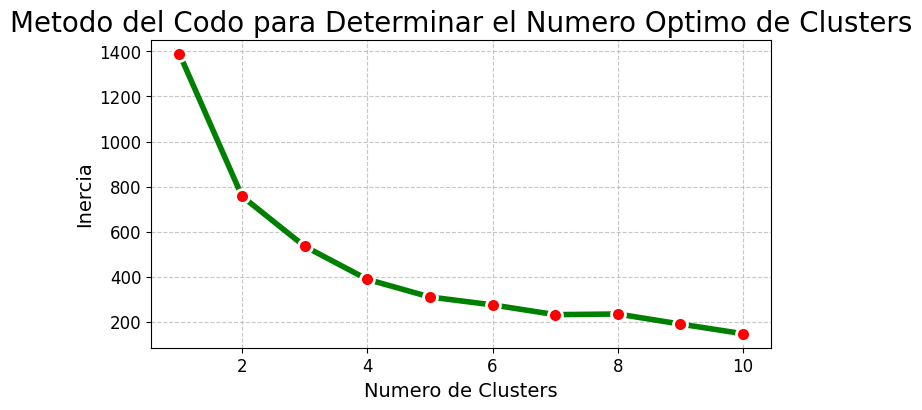

In [ ]:
# Tomamos los datos del primer trimestre de 2025 para el Elbow Method
datos_clustering = analisis_rfm[analisis_rfm['TRIMESTRE'] == '2025Q1'][['PUNTAJE_RECENCIA', 'PUNTAJE_FRECUENCIA', 'PUNTAJE_MONETARIO']]

inercia = []

#Aplicamos el algoritmo KMeans con varias cantidades de clusters 
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(datos_clustering)
    inercia.append(kmeans.inertia_)

# Hacemos la visualización para escoger el numero de clusters ideal
plt.figure(figsize=(8, 4))

sns.lineplot(x=range(1, 11), y=inercia, color='green',
             linewidth=4, marker='o', markersize=10,
             markerfacecolor='red', markeredgewidth=2)

plt.xlabel('Numero de Clusters', fontsize=14)
plt.ylabel('Inercia', fontsize=14)
plt.title('Metodo del Codo para Determinar el Numero Optimo de Clusters', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()



In [ ]:
# Ahora, aplicamos el algoritmo KMeans con k = 3 para segmentar todo el dataset según su grupo RFM y trimestre 

#Filtramos el dataset para obtener los datos columnas que necesitamos
datos_clustering = analisis_rfm[['PUNTAJE_RECENCIA', 'PUNTAJE_FRECUENCIA', 'PUNTAJE_MONETARIO']]

#Aplicamos el algoritmo
kmeans_best = KMeans(n_clusters = 3,
                     random_state = 42,
                     n_init = 10)

kmeans_best.fit(datos_clustering)
labels = kmeans_best.predict(datos_clustering)

#Segun el resultado del clustering, aplicamos los labels
analisis_rfm['CLASIFICACION'] = labels

#Vemos como se comporta cada cluster
analisis_rfm['PUNTAJE_FRECUENCIA'] = datos_clustering['PUNTAJE_FRECUENCIA'].astype(int)
analisis_rfm['PUNTAJE_RECENCIA'] = datos_clustering['PUNTAJE_RECENCIA'].astype(int)
analisis_rfm['PUNTAJE_MONETARIO'] = datos_clustering['PUNTAJE_MONETARIO'].astype(int)
print("Comportamiento de cada cluster según su RECENCIA, FRECUENCIA, GASTO MONETARIO Y CANTIDAD TOTAL:")
print(analisis_rfm.groupby('CLASIFICACION').agg({'PUNTAJE_RECENCIA': 'mean', 'PUNTAJE_FRECUENCIA': 'mean', 'PUNTAJE_MONETARIO': 'mean', 'CANTIDAD_TOTAL':'mean'}))
#print(datos_clustering['Cluster'].value_counts())

#Mapeamos cada clasificación con una etiqueta que indique la categoría a la que pertenece el cliente
analisis_rfm['CLASIFICACION'] = analisis_rfm['CLASIFICACION'].map({0: 'Cliente en Riesgo', 1: 'Cliente Regular', 2: 'Cliente Leal'})

Comportamiento de cada cluster según su RECENCIA, FRECUENCIA, GASTO MONETARIO Y CANTIDAD TOTAL:
               PUNTAJE_RECENCIA  PUNTAJE_FRECUENCIA  PUNTAJE_MONETARIO  \
CLASIFICACION                                                            
0                      2.936867            1.651598           1.933749   
1                      2.711163            3.497268           3.751756   
2                      4.898511            3.908902           3.578802   

               CANTIDAD_TOTAL  
CLASIFICACION                  
0                 1036.431800  
1                 7457.928181  
2                 5754.485625  


In [ ]:
# Hacemos una tabla de frecuencia para ver la cantidad de clientes en cada grupo RFM por trimestre
analisis_rfm.groupby('TRIMESTRE')['CLASIFICACION'].value_counts().unstack().fillna(0)

CLASIFICACION,Cliente Leal,Cliente Regular,Cliente en Riesgo
TRIMESTRE,,,
2023Q1,186,11,158
2023Q2,171,61,142
2023Q3,214,36,144
2023Q4,108,137,155
2024Q1,148,117,152
2024Q2,185,123,137
2024Q3,264,102,108
2024Q4,252,167,75
2025Q1,326,139,42


## Cambios en el puntaje RFM 

En la tabla anterior podemos observar que aunque los Clientes Leales han aumentado significativamente desde el 2023 y han disminuido los Clientes en Riesgo, en cada trimestre del 2025 han ido en aumento los Clientes en Riesgo. Además, en el último trimestre de 2025 disminuyó el número de Clientes Leales, sin embargo, es importante notar que parece que este comportamiento es común para los últimos trimestres de cada año. 

In [ ]:
#Observamos como se comporta el PUNTAJE_RFM en cada trimestre y corroboramos lo mencionado anteriormente

analisis_rfm.groupby('TRIMESTRE')['PUNTAJE_RFM'].describe()

,count,mean,std,min,25%,50%,75%,max
TRIMESTRE,,,,,,,,
2023Q1,355.0,9.507042,2.805731,3.0,8.0,10.0,12.0,14.0
2023Q2,374.0,9.639037,2.686612,3.0,8.0,10.0,12.0,15.0
2023Q3,394.0,9.659898,3.091656,3.0,7.0,10.0,12.0,15.0
2023Q4,400.0,9.162500,2.858588,3.0,7.0,10.0,11.0,15.0
2024Q1,417.0,9.338129,2.762787,3.0,7.0,9.0,11.0,14.0
2024Q2,445.0,9.943820,2.821090,3.0,8.0,10.0,12.0,15.0
2024Q3,474.0,10.500000,2.761292,3.0,9.0,11.0,13.0,15.0
2024Q4,494.0,10.635628,2.486643,3.0,9.0,11.0,13.0,15.0
2025Q1,507.0,11.668639,2.168920,3.0,11.0,12.0,13.0,15.0


In [ ]:
# Encontramos a los clientes cuyo RMF promedio haya bajado más desde el año pasado 

puntaje_2025 = analisis_rfm[analisis_rfm['TRIMESTRE'].astype(str).isin(['2025Q1', '2025Q2', '2025Q3', '2025Q4'])].groupby('CODCLI')['PUNTAJE_RFM'].mean()
puntaje_2024 = analisis_rfm[analisis_rfm['TRIMESTRE'].astype(str).isin(['2024Q1', '2024Q2', '2024Q3', '2024Q4'])].groupby('CODCLI')['PUNTAJE_RFM'].mean()

declive_puntaje = puntaje_2025 - puntaje_2024
declive_puntaje[declive_puntaje < -1].sort_values()

CODCLI
B636   -4.250000
2622   -3.333333
2145   -3.250000
C044   -3.250000
D607   -3.000000
4244   -3.000000
Y131   -2.750000
6442   -2.750000
1340   -2.500000
1931   -2.500000
2144   -2.500000
8824   -2.500000
8268   -2.500000
A037   -2.250000
C078   -2.250000
4661   -2.250000
C928   -2.250000
B365   -2.250000
5023   -2.000000
2692   -2.000000
B901   -2.000000
D522   -2.000000
C498   -2.000000
A546   -1.750000
A525   -1.750000
-153   -1.750000
P70    -1.750000
-216   -1.750000
4168   -1.750000
-1     -1.500000
A919   -1.500000
A976   -1.500000
J30    -1.500000
A028   -1.500000
C030   -1.500000
9373   -1.500000
G167   -1.250000
D638   -1.250000
D104   -1.250000
A610   -1.250000
711    -1.250000
8284   -1.250000
A043   -1.250000
B366   -1.250000
B350   -1.250000
C887   -1.250000
C095   -1.250000
Name: PUNTAJE_RFM, dtype: float64

In [ ]:
# Encontramos el nombre de la farmacia que tuvo el declive en PUNTAJE RFM más alto  

clientes[clientes['CODCLI'] == 'B636']

,CODCLI,NOMCLI,FECHAING,CADENA
319,B636,Farmacia Iker Alivio,15/8/2022 0:36,GRUPO Esperanza Estrella


## Modelo de predicción 

Para predecir el comportamiento de los clientes en los próximos trimestres y anticipar pérdidas de clientes, se aplicó el modelo de predicción para series temporales conocido como ARIMA. 

Antes de seleccionar el modelo a usar, visualizamos cómo ha variado el puntaje RFM promedio usando una serie de tiempo por trimestres; debido a que los datos históricos son confiables, no incluyen huecos o comportamientos estacionales y muestran una tendencia positiva, es posible usar un modelo de predicción como ARIMA

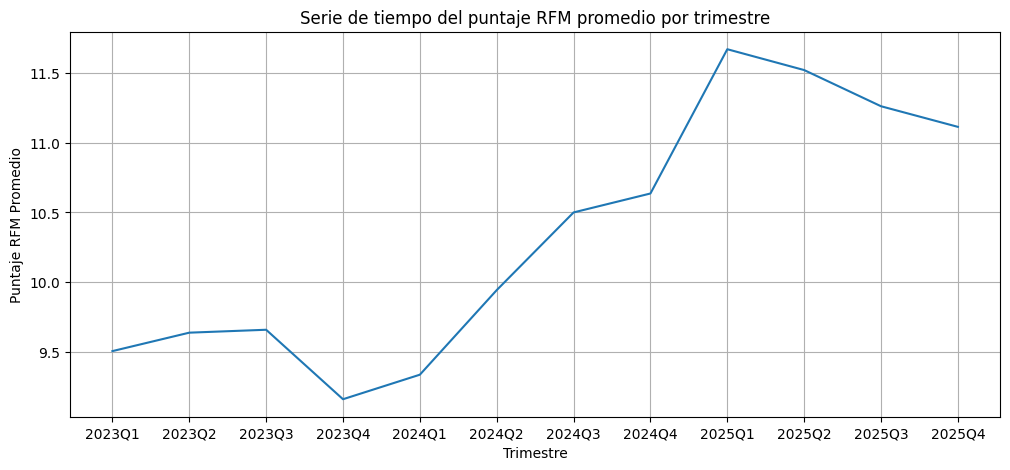

In [ ]:
#Gradicamos cómo ha fluctiuado el PUNTAJE RFM promedio a través de los años

plt.figure(figsize=(12,5))
plt.plot(analisis_rfm['TRIMESTRE'].unique().astype(str), analisis_rfm.groupby('TRIMESTRE')['PUNTAJE_RFM'].mean())
plt.title("Serie de tiempo del puntaje RFM promedio por trimestre")
plt.xlabel("Trimestre")
plt.ylabel("Puntaje RFM Promedio")
plt.grid(True)
plt.show()

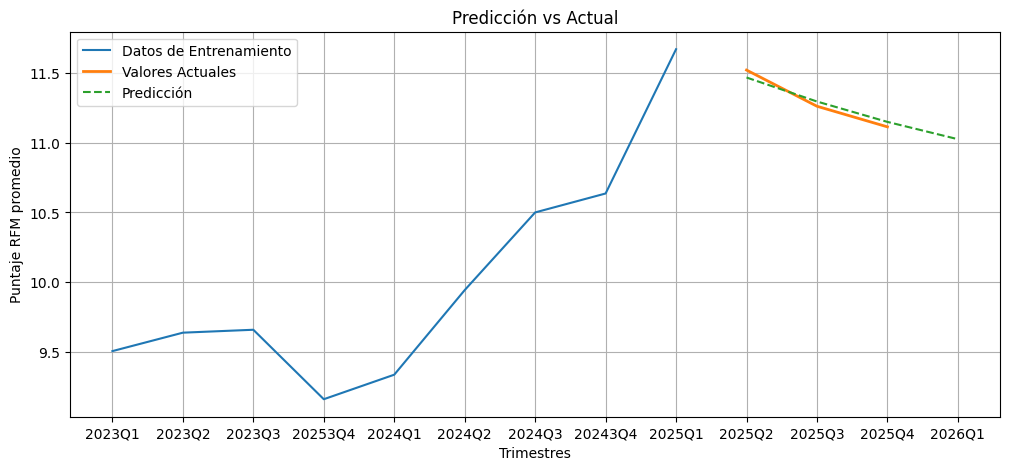

In [37]:
# Entrenamos el modelo ARIMA
train = analisis_rfm.groupby('TRIMESTRE')['PUNTAJE_RFM'].mean()[:-3]
test = analisis_rfm.groupby('TRIMESTRE')['PUNTAJE_RFM'].mean()[-3:]
modelo_arima = pm.auto_arima(train, seasonal=False)

# Evaluación 
prediccion = modelo_arima.predict(n_periods=4)
prediccion = pd.Series(prediccion)
plt.figure(figsize=(12,5))
plt.plot(['2023Q1', '2023Q2', '2023Q3', '20253Q4', '2024Q1', '2024Q2', '2024Q3', '20243Q4', '2025Q1'], train.values, label='Datos de Entrenamiento')
plt.plot(['2025Q2', '2025Q3', '2025Q4'], test.values, label='Valores Actuales', linewidth=2)
plt.plot(['2025Q2', '2025Q3', '2025Q4', '2026Q1'], prediccion.values, label='Predicción', linestyle="--")
plt.title("Predicción vs Actual")
plt.xlabel("Trimestres")
plt.ylabel("Puntaje RFM promedio")
plt.legend()
plt.grid(True)
plt.show()


## Conlusiones y Recomendaciones para el Negocio

Tenemos que la predicción realizada se ajusta bastante a los valores actuales, por lo que podemos observar que el PUNTAJE RFM va disminuyendo, pero no de forma dramática. No obstante, estas son las señales tempranas que nos dan los datos antes de que aumente el churn rate de clientes, por lo que es importante poner en acción estrategias de retención de clientes. 

### Estrategia de Negocio: 

En primer lugar, se recomienda conservar a los clientes clasificados como “Clientes Leales” y “Clientes Regulares” a través de descuentos y promociones para recompensar su fidelidad. Además, debido a la alta cantidad de clientes que entran en estas categorías se recomienda identificar aquellos clientes que aportan el mayor lifetime value y ofrecerles una atención personalizada para garantizar su lealtad.

Luego, en cuanto a aquellos clientes en la zona de riesgo, se recomienda la activación de campañas dirigidas directamente a estos clientes que contengan recordatorios de lo que ofrece Droguería Nena e incluya descuentos exclusivos. 

### Recomendaciones Adicionales: 
* Se recomendaría estudiar más a fondo las razones por las que los clientes puedan estar prefiriendo a la competencia. 
* Estudiar a mayor profundidad lo que se conoce como "compras mínimas" o "de relleno". 
* Hacer el estudio de forma mensual en vez de trimestral para obversar con mayor granularidad el comportamiento de compra de los clientes, además una mayor cantidad de datos beneficiará al modelo de predicción.

## Exportamos el dataset resultante

In [36]:
export_dataset = analisis_rfm.copy()

export_dataset=pd.merge(export_dataset, clientes[['CODCLI', 'NOMCLI','CADENA']], on='CODCLI', how='left')
export_dataset.drop(columns=['CODCLI', 'TRIMESTRE'], inplace=True)
export_dataset.to_csv('reporte_trimestral_clientes_RFM.csv', index=False)